# Conditional Generation

참조 : Coursera : 
Build Basic Generative Adversarial Networks (GANs)

## content

Conditional vs Unconditional Generation
- **Conditional**
  * Examples from the classes you want
  * Training datasets needs to be labeled
- **Unconditional**
  * Examples from random classes
  * Training dataset doesn't need to be labeled

conditional Generation에선 일반적인 Generator Input인 noise와 해당 class를 의미하는 one-hot vector가 필요하다.  이 ont-hot vector는 Control in the generation이다.

이 noise와 원핫 벡터를 합쳐 하나의 큰 벡터로 만들어서 input으로 준다.

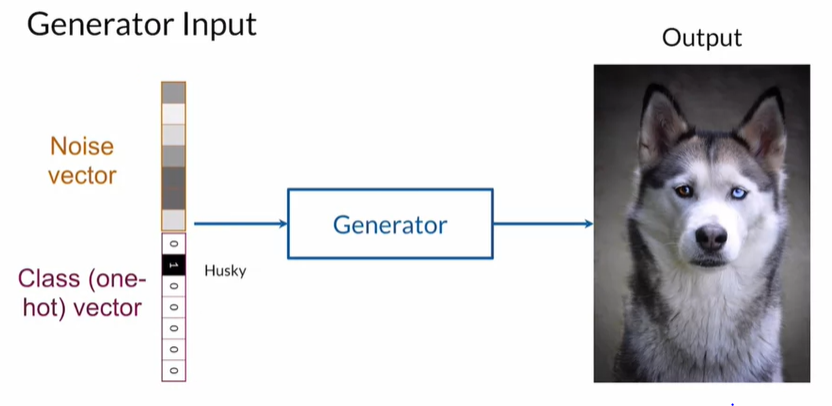

Discriminator는 진짜 이미지와 이미지의 라벨을 입력으로 받는다.

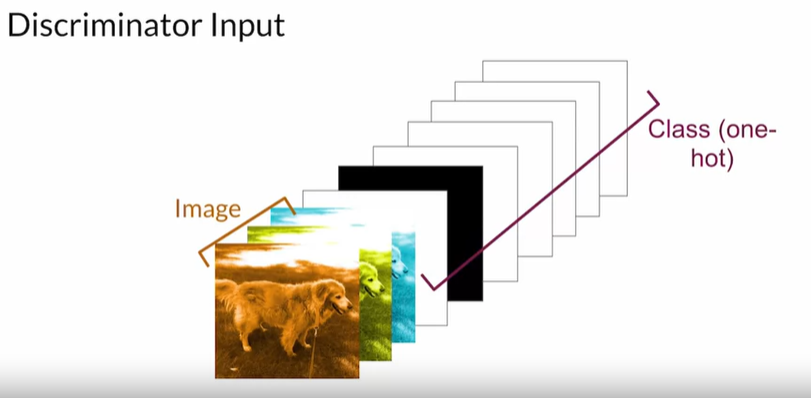

진짜 이미지는 3채널이고 나머지 채널들은 원핫 인코딩을 통해 해당 라벨을 의미하는 채널만 전부 값을 채워넣고 나머지는 0으로 채운다.

- the class is passed to the generator as one-hot vectors
- the class is passed to the discriminator as one-hot matrices
- the size of the vector and the number of matrices represent the number of classes

## Code

In [2]:
!nvidia-smi

Tue Jan  4 07:36:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.cuda import is_available
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import os
torch.manual_seed(0)
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [4]:
device='cuda' if is_available() else 'cpu'

generator and noise

In [82]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Generator(nn.Module):
  def __init__(self,z_dim = 10 , img_dim = 1,hidden_dim=64):
    super(Generator,self).__init__()
    self.z_dim = z_dim
    self.generator = nn.Sequential(
        self.gen_block(z_dim,hidden_dim * 4),
        self.gen_block(hidden_dim*4,hidden_dim*2,kernel_size=4,stride=1),
        self.gen_block(hidden_dim*2,hidden_dim),
        self.gen_block(hidden_dim,img_dim,kernel_size=4,final_layer=True)
    )

  def gen_block(self,input_dim,output_dim,kernel_size=3,stride=2,final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(input_dim,output_dim,kernel_size,stride=stride)
          ,nn.BatchNorm2d(output_dim)
          ,nn.ReLU(inplace=True)
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_dim, output_dim,kernel_size,stride),
          nn.Tanh()
                     )
  def forward(self,x):
    x = x.view(len(x),self.z_dim,1,1)
    return self.generator(x)
def get_noise(n_samples, input_dim, device='cpu'):
    return torch.randn(n_samples, input_dim, device=device)

Discriminator

In [83]:
class Discriminator(nn.Module):
  def __init__(self,img_dim=1,hidden_dim=64):
    super(Discriminator,self).__init__()
    self.critic = nn.Sequential(
        self.critic_block(img_dim,hidden_dim),
        self.critic_block(hidden_dim,hidden_dim*2),
        self.critic_block(hidden_dim*2,1,final_layer=True)
    )
  def critic_block(self,input_dim,output_dim,kernel_size=4,stride=2,final_layer=False ):
      if not final_layer:
        return nn.Sequential(
            nn.Conv2d(input_dim,output_dim,kernel_size,stride,1 ),
            nn.BatchNorm2d(output_dim),
            nn.LeakyReLU(0.2,inplace=True)
        )
      else:
        return nn.Sequential(
            nn.Conv2d(input_dim,output_dim,kernel_size,1)
        )
  def forward(self,x):
    critic_predict = self.critic(x)
    return critic_predict.view(len(critic_predict),-1)

#### class input   

In conditional GANs, the input vector for the generator will also need to include the class information. 


In [84]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes): 
  #labels is a img_label, n_classes is the number of the classes
    label = F.one_hot(labels,n_classes)
    return label
  #return one-hot vector

you need to be able to concatenate the one-hot class vector to the noise vector before giving it to the generator

In [85]:
def combine_vectors(x, y):
  # x is a noise vector with shapes( n_samples,z_dim)
  # y is a one-hot class vector with shapes(n_samples,n_classes)
    combined = torch.cat((x.float(),y.float()),1)
    return combined

training Mnist


In [86]:
mnist_shape = (1, 28, 28)
n_classes = 10

In [99]:
criterion = nn.BCEWithLogitsLoss() # loss function
n_epochs = 10 #epochs
z_dim = 64 # noise dim
display_step = 500 # display period
batch_size = 128 # batch size
lr = 0.0002 # learning rate

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [100]:
# GRADED FUNCTION: get_input_dimensions
def get_input_dimensions(z_dim, mnist_shape, n_classes):

    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes

    return generator_input_dim, discriminator_im_chan

In [101]:
input_dim, img_dim = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(z_dim=input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(img_dim=img_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Training ::   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 2.984221797823906, critic loss: 0.15508952995017172


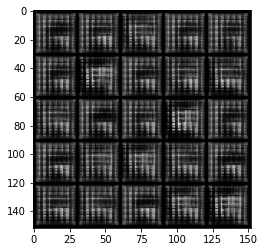

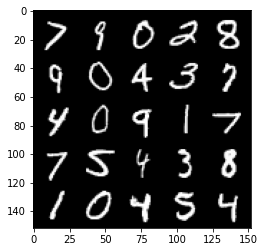

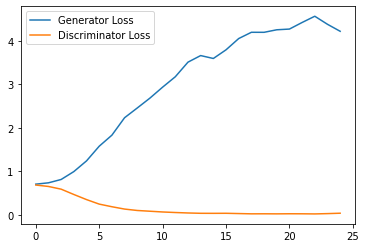

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 3.436299708366394, critic loss: 0.12732230864837765


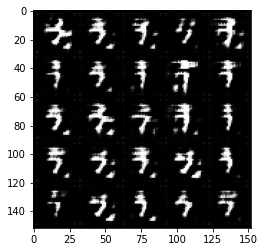

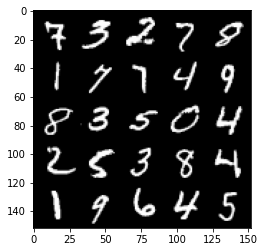

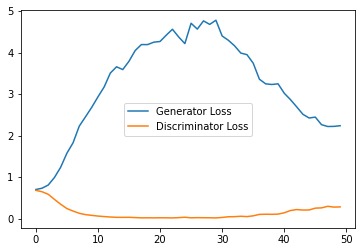

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 1.867777663230896, critic loss: 0.32909245416522026


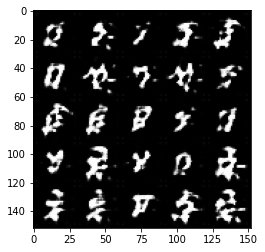

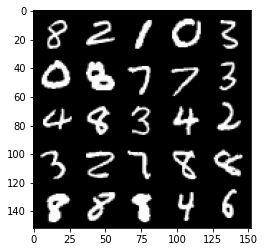

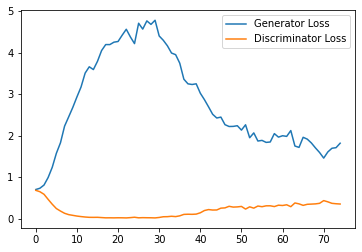

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 1.5970535140037536, critic loss: 0.3927759737372398


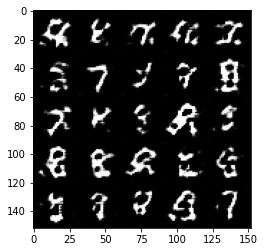

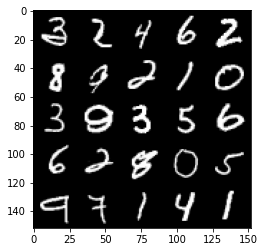

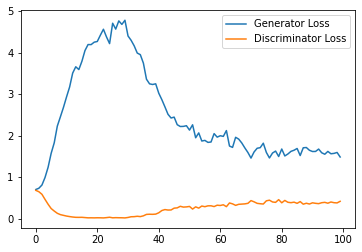

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 1.52126030421257, critic loss: 0.41558224326372145


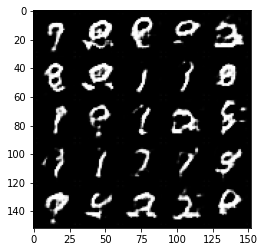

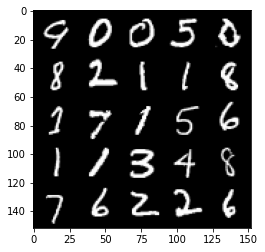

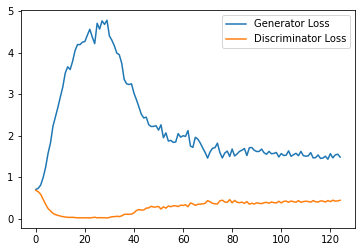

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 1.4258544585704804, critic loss: 0.4471848704814911


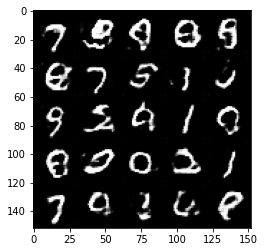

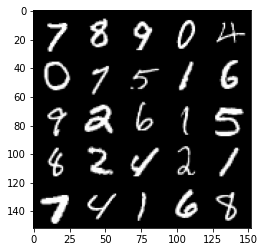

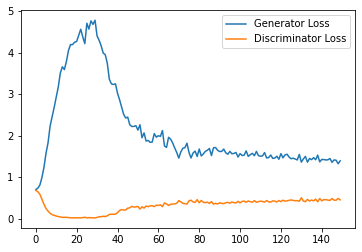

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 1.3306359069347382, critic loss: 0.4847149114012718


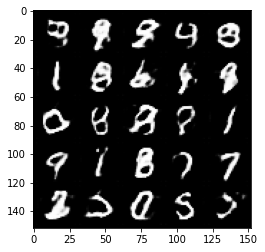

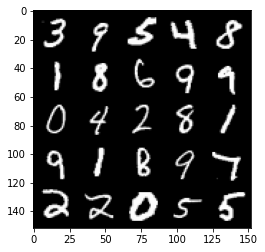

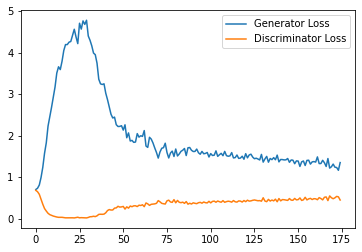

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 1.2199762424230576, critic loss: 0.5229738963246345


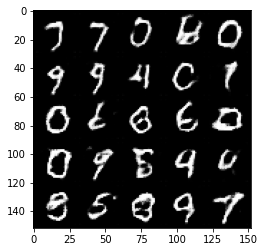

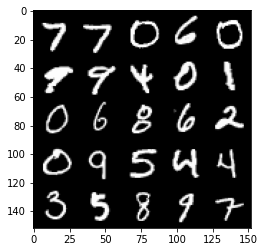

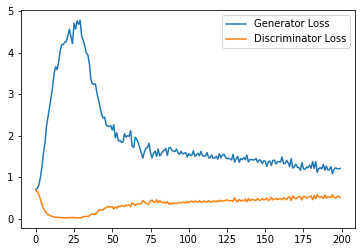

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 1.1791389039754867, critic loss: 0.5442871108055115


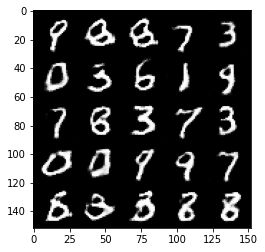

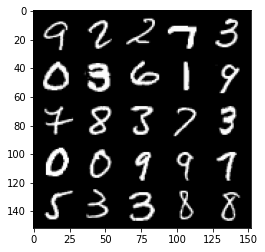

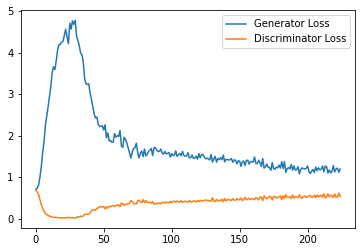

In [103]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
cur_step = 0
g_losses = []
d_losses = []

noise_and_labels = False
fake = False
real_img_and_label = False
fake_img_and_label = False
disc_fake_pred = False
disc_real_pred = False

for epoch in tqdm_notebook(range(n_epochs),desc="Training :"):
    for real, labels in tqdm_notebook(dataloader,leave=False):
        cur_batch_size = len(real)
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device),n_classes)
        img_one_hot_labels = one_hot_labels[:,:,None,None]
        img_one_hot_labels = img_one_hot_labels.repeat(1,1,mnist_shape[1],mnist_shape[2])
        
        #update discriminator
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size,z_dim,device=device)

        noise_and_labels = combine_vectors(fake_noise,one_hot_labels)
        fake = gen(noise_and_labels)

        fake_image_and_labels = combine_vectors(fake.detach(),img_one_hot_labels)
        real_image_and_labels = combine_vectors(real,img_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)
        
        disc_fake_loss = criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred,torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss+disc_real_loss)/2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        d_losses += [disc_loss.item()] 

        # Update Generator
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake,img_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred,torch.ones_like(disc_fake_pred))
        gen_loss.backward()

        gen_opt.step()

        g_losses += [gen_loss.item()]

        # Visualization code
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(g_losses[-display_step:]) / display_step
            crit_mean = sum(d_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(g_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(g_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(d_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1